In [1]:
# dependent modules in this project
import pickle
import csv

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import sklearn.model_selection
import tensorflow as tf

## Step 0: Load The Data

In [2]:
# Load pickled data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
# map csv file

dict_id_signName = {}

#read signnames.csv
with open('signnames.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        dict_id_signName[(int(row['ClassId']))] = row['SignName']

print (dict_id_signName)

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

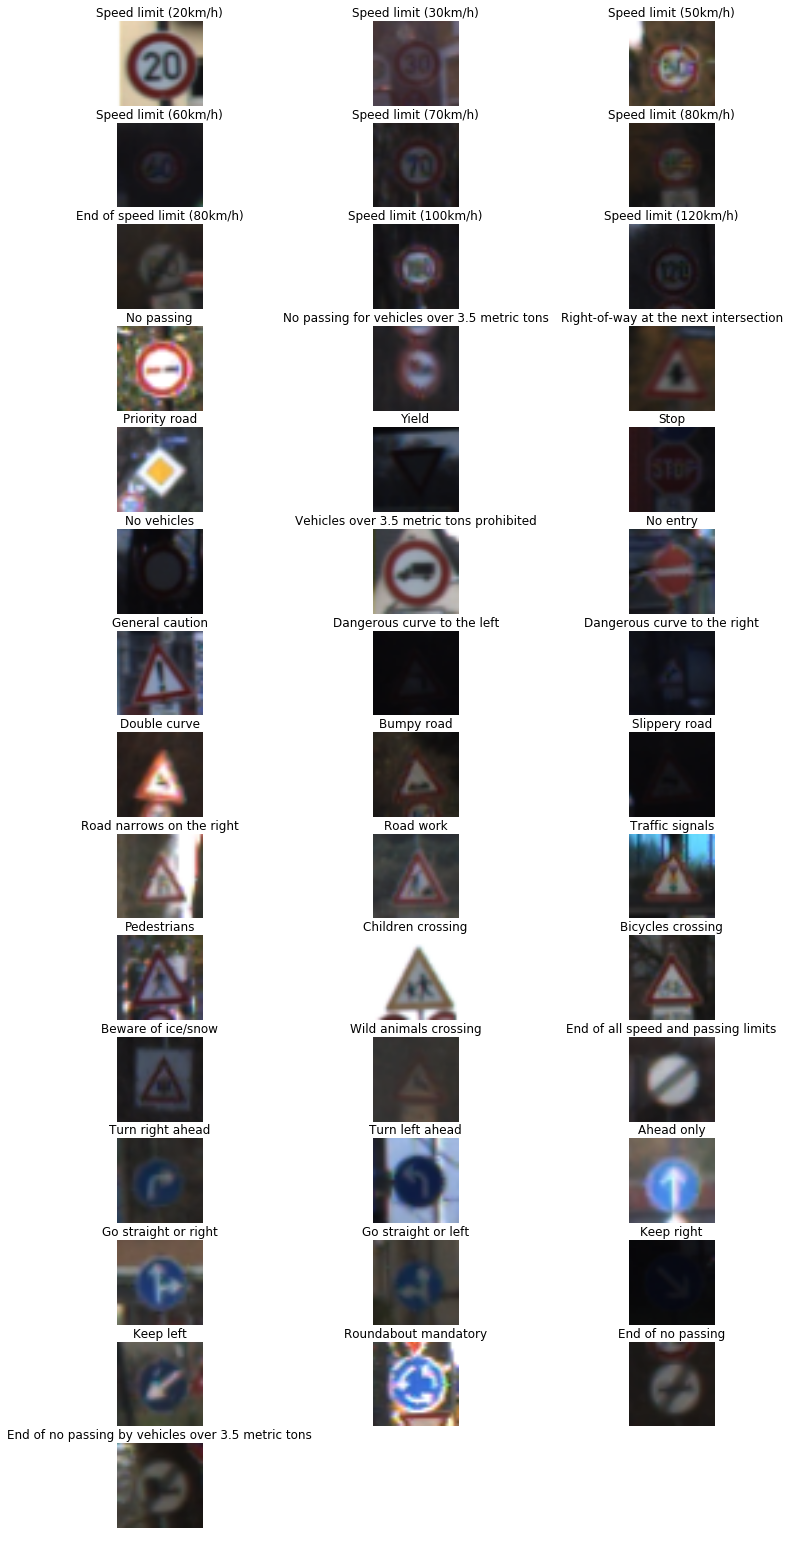

In [5]:
# I was using the idea of NikolasEnt on github in this block
n_imgsPerClass=[]
plt.figure(figsize=(13, 27))
for i in range(0, n_classes):
    plt.subplot(15, 3, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #draw the first image of each class
    plt.title(dict_id_signName[i])
    plt.axis('off')
    n_imgsPerClass.append(len(x_selected))
plt.show()


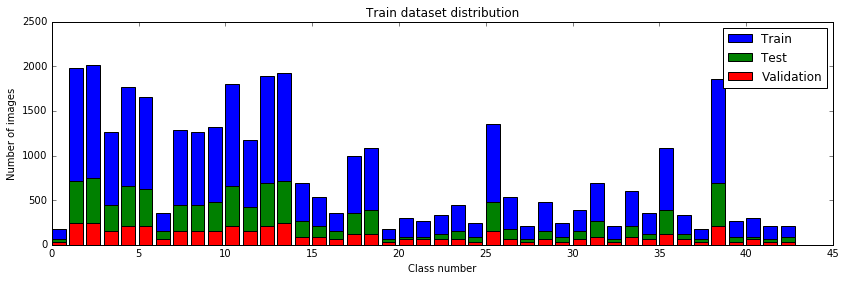

Stats : Min in a class 180, Max in a class 2010


In [6]:
# plot distribution based on images in each class
plt.figure(figsize=(14, 4))
plt.bar(range(0, n_classes), np.bincount(y_train), label='Train')
plt.bar(range(0, n_classes),np.bincount(y_test), color='g',label='Test')
plt.bar(range(0, n_classes),np.bincount(y_valid), color='r',label='Validation')
plt.title("Train dataset distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.legend()
plt.show()

print("Stats : Min in a class {}, Max in a class {}".format( min(n_imgsPerClass), max(n_imgsPerClass) ))

We can see from the plot that some classes contain less data. So affine transformations and filters can be applied on them so that we can generate a larger data set to train the model

In [7]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

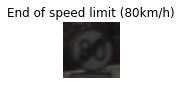

In [8]:
#randomly pick some dataset sample to check if they are properly matched
import matplotlib.image as mpimg

rand_num = 9410
img = X_train[rand_num]

plt.figure(figsize =(1,1))
plt.imshow(img)
plt.title(dict_id_signName[y_train[rand_num]])
plt.axis('off')
plt.show()

In [9]:
# generating additional data
X_train_adnl = np.concatenate((X_train, X_valid))
y_train_adnl = np.concatenate((y_train, y_valid))

import scipy.ndimage

angles = [-5, 5, -10, 10, -13, 13, -17, 17]

for i in range(len(n_imgsPerClass)):
    if n_imgsPerClass[i] >= 1000:
        continue

    new_x = []
    new_y = []
    mask = np.where(y_train_adnl == i)

    for j in range(3):
        for feature in X_train_adnl[mask]:
            new_x.append(scipy.ndimage.rotate(feature, angles[j], reshape=False))
            new_y.append(i)

    X_train_adnl = np.append(X_train_adnl, new_x, axis=0)
    y_train_adnl = np.append(y_train_adnl, new_y, axis=0)

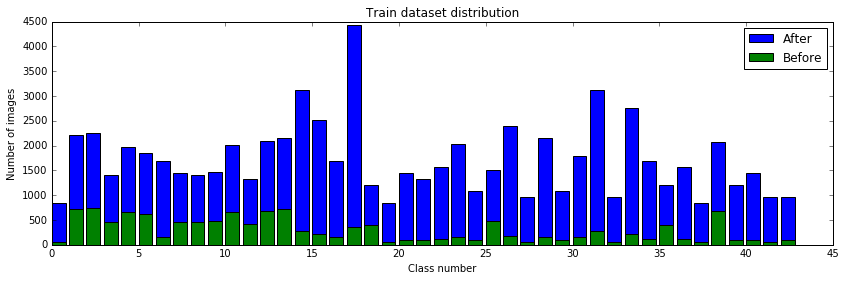

Stats : Min in a class 840, Max in a class 4440


In [10]:
# plot distribution based on images in each class
plt.figure(figsize=(14, 4))
plt.bar(range(0, n_classes), np.bincount(y_train_adnl), label='After')
plt.bar(range(0, n_classes),np.bincount(y_test), color='g',label='Before')
plt.title("Train dataset distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.legend()
plt.show()

print("Stats : Min in a class {}, Max in a class {}".format( min(np.bincount(y_train_adnl)), max(np.bincount(y_train_adnl)) ))

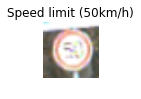

In [11]:
from sklearn.utils import shuffle
X_train_adnl, y_train_adnl = shuffle(X_train_adnl, y_train_adnl)

#randomly pick some dataset sample to check if they are properly matched
import matplotlib.image as mpimg

rand_num = 9410
img = X_train_adnl[rand_num]

plt.figure(figsize =(1,1))
plt.imshow(img)
plt.title(dict_id_signName[y_train_adnl[rand_num]])
plt.axis('off')
plt.show()

As we can see there are less samples in some particular class and augmenting data by rotation can provide addtional data which can be used by the model to train. Care should be taken for overfitting of data.

As the pixel value lies in (0,255) normalization of data prevents creaping up of loss function because of skewed shape

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Before training the model, each pixel need to be normalized to avoid increase of loss function

### Model Architecture

In [12]:
# Initial Setup for Keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


### Train and Validate the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

A Convolution Layer with 32 filters and kernel size of 3 and stride of 3 is selected in 1st layer and the output is flattened and outputted to 128 neurons and final output layer which was fully connected has 43 logits 

In [13]:
from sklearn.model_selection import train_test_split
X_train_adnl, X_valid_adnl, y_train_adnl, y_valid_adnl = train_test_split(X_train_adnl, y_train_adnl, test_size=0.2, stratify = y_train_adnl )

In [14]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(43, activation='softmax'))

# normalize data
X_train_adnl = np.array(X_train_adnl / 128.0 - 1 )
X_valid_adnl = np.array(X_valid_adnl / 128.0 - 1 )
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_onehot_train_adnl = label_binarizer.fit_transform(y_train_adnl)
y_onehot_valid_adnl = label_binarizer.fit_transform(y_valid_adnl)

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 30, 30, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 28800)         0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 128)           3686528     flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 43)            5547        dense_1[0][0]                    
Total params: 3,692,971
Trainable params: 3,692,971
Non-trainable params: 0
_______________

In [16]:
model.compile('adam', loss ='categorical_crossentropy',metrics = ['accuracy'])
#history = model.fit(X_train_adnl, y_one_hot, nb_epoch=7, validation_split=0.2)
history_1 = model.fit(X_train_adnl, y_onehot_train_adnl,
                    batch_size=256, nb_epoch=7,
                    verbose=1, validation_data=(X_valid_adnl, y_onehot_valid_adnl))


Train on 59228 samples, validate on 14808 samples
Epoch 1/7
59228/59228 [==============================] - 10s - loss: 0.7751 - acc: 0.8012 - val_loss: 0.2213 - val_acc: 0.9491
Epoch 2/7
59228/59228 [==============================] - 7s - loss: 0.1476 - acc: 0.9661 - val_loss: 0.1205 - val_acc: 0.9715
Epoch 3/7
59228/59228 [==============================] - 7s - loss: 0.0784 - acc: 0.9825 - val_loss: 0.0968 - val_acc: 0.9786
Epoch 4/7
59228/59228 [==============================] - 7s - loss: 0.0528 - acc: 0.9874 - val_loss: 0.0781 - val_acc: 0.9826
Epoch 5/7
59228/59228 [==============================] - 7s - loss: 0.0379 - acc: 0.9916 - val_loss: 0.1006 - val_acc: 0.9741
Epoch 6/7
59228/59228 [==============================] - 7s - loss: 0.0358 - acc: 0.9912 - val_loss: 0.0844 - val_acc: 0.9797
Epoch 7/7
59228/59228 [==============================] - 7s - loss: 0.0284 - acc: 0.9932 - val_loss: 0.0675 - val_acc: 0.9833


First I tried with LeNet architecture which got me to 89% training accuracy. Later I added dropouts and Relu but still the validation accuracy was 89%.

I tried training for more epochs till 20 tried adding 1 more convolution layer with increased training accuracy to 96% but validation accuracy was under 91%

Then I tried a Convolution network with 2 fully connected layers which reached 99% training accuracy and 97% validation accuracy.

### Testing of Model

In [17]:
X_test_norm = np.array(X_test / 128.0 - 1 )
y_one_hot_test = label_binarizer.fit_transform(y_test)

metrics = model.evaluate(X_test_norm, y_one_hot_test)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))

12630/12630 [==============================] - 2s     
loss: 0.618003577168556
acc: 0.8887569280153971


Inspite of high training and validation accuracy test_accuracy is low because of overfitting in the model

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Testing on images from Web

In [18]:
import os
list_testimages=os.listdir("newtest/")
list_testimages=shuffle(list_testimages) #just added to check if still order is perceived

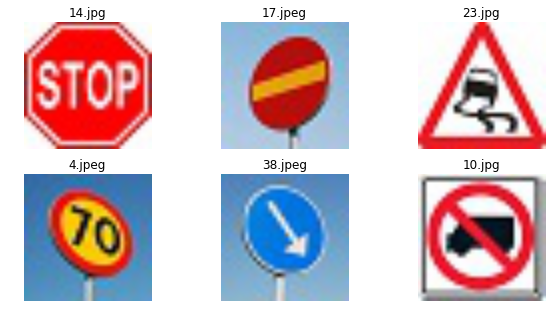

In [19]:
X_pred = []
def show_imgs(list_imgs):
    plt.figure(figsize=(10, 5))
    for i in range(len(list_imgs)):
        plt.subplot(2, 3, i+1)
        test_image= mpimg.imread("newtest/"+list_imgs[i])
        plt.imshow(test_image)
        plt.title(list_imgs[i])
        plt.axis('off')
        X_pred.append(test_image)
    plt.show()

show_imgs(list_testimages)
X_pred = np.array(X_pred)

#images maped with their codes in German Data Set

In [20]:
#Normalize prediction data
X_pred_norm = np.array(X_pred / 128.0 - 1 )
pred_data = model.predict_classes(X_pred_norm) #predict_classes gives most probable output of all classes

6/6 [==============================] - 0s


### Predictions from Built Model
#### Data Set 1

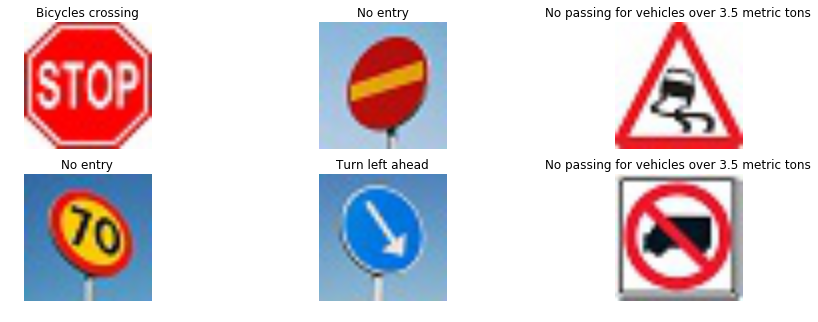

In [21]:
plt.figure(figsize=(15,5))
for index,pred in enumerate(pred_data):
    plt.subplot(2,3,index+1)
    plt.imshow(X_pred[index])
    plt.title(dict_id_signName[pred])
    plt.axis('off')
plt.show()

In [22]:
#again some sort of repetion wanted to include everything in same function
#but matplotlib outputs images after execution of the chunk which is not desired
#
# using model.predict outputs all 43 class probabilities .. now printing only top 5 of X_webimages
def predict_top5(X_data_original):
    #normalize the data before processing
    X_data = np.array(X_data_original / 128.0 - 1 )
    X_data = X_data.reshape((len(X_data),32,32,3))
    all_img_predictions=model.predict(X_data)
    for each_img_pred in all_img_predictions:
        top5_preds_index = np.argsort(each_img_pred)[-5:]
        for index,each_index in enumerate(top5_preds_index):
            print('({:2}){:50}: {:2f}'.format(each_index,dict_id_signName[each_index], each_img_pred[each_index]))
        print("----")
        
predict_top5(X_pred)

( 5)Speed limit (80km/h)                              : 0.000055
(17)No entry                                          : 0.000090
(25)Road work                                         : 0.095803
( 1)Speed limit (30km/h)                              : 0.101369
(29)Bicycles crossing                                 : 0.802684
----
(25)Road work                                         : 0.000000
( 1)Speed limit (30km/h)                              : 0.000000
(10)No passing for vehicles over 3.5 metric tons      : 0.000000
(14)Stop                                              : 0.005399
(17)No entry                                          : 0.994601
----
(19)Dangerous curve to the left                       : 0.000009
(38)Keep right                                        : 0.000017
( 9)No passing                                        : 0.000042
( 2)Speed limit (50km/h)                              : 0.056449
(10)No passing for vehicles over 3.5 metric tons      : 0.943482
----
( 3)Speed 

### Analyze Performance

The stop sign used was an infographic content rather than a board sign, So it might have detected more features than trained which might lead to confusion.

No entry has been correctly classified.

Some similarity of black object inside red boarder might have classified slippery road wrong

Yellow patch inside Red circle might have missclassfied speed limit board

While aumenting data rotation of image for these kind of data sets is not a good idea

Correct classification of No passing for vehicles over 3.5 metric tons 